In [4]:
from keras import layers
from keras import models
from keras import optimizers
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
import keras.utils.np_utils as kutils
import numpy as np
from keras import backend as K

/home/yxu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
img_rows, img_cols = 32, 32
(trainX, trainY), (testX, testY) = cifar10.load_data()
trainX = trainX / 255
testX = testX / 255
trainX = trainX.astype('float32')
testX = testX.astype('float32')
trainY = kutils.to_categorical(trainY)
testY = kutils.to_categorical(testY)

In [10]:
# initial model define
model = models.Sequential()
model.add(layers.Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 3), kernel_initializer='random_normal'))
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Conv2D(16, (5, 5), activation='relu', kernel_initializer='random_normal'))
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(120, activation='relu'))
model.add(layers.Dense(84, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
sgd = optimizers.SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])
history = model.fit(trainX, trainY, epochs=50, batch_size=64, validation_data=(testX, testY))
print("Finished compiling 1")

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 118us/step - loss: 2.1783 - acc: 0.1768 - val_loss: 2.0877 - val_acc: 0.2190
Epoch 2/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.9365 - acc: 0.2992 - val_loss: 2.1196 - val_acc: 0.2711
Epoch 3/50
50000/50000 [==============================] - 5s 106us/step - loss: 1.7964 - acc: 0.3626 - val_loss: 1.7168 - val_acc: 0.3903
Epoch 4/50
50000/50000 [==============================] - 5s 106us/step - loss: 1.6846 - acc: 0.4011 - val_loss: 1.7552 - val_acc: 0.3797
Epoch 5/50
50000/50000 [==============================] - 5s 104us/step - loss: 1.6053 - acc: 0.4281 - val_loss: 1.5668 - val_acc: 0.4378
Epoch 6/50
50000/50000 [==============================] - 5s 104us/step - loss: 1.5298 - acc: 0.4533 - val_loss: 1.5502 - val_acc: 0.4479
Epoch 7/50
50000/50000 [==============================] - 5s 105us/step - loss: 1.4844 - acc: 0.4683 - val_loss: 1.4477 - 

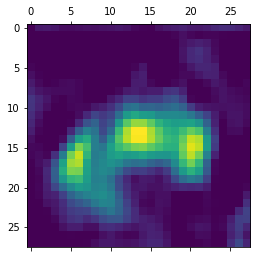

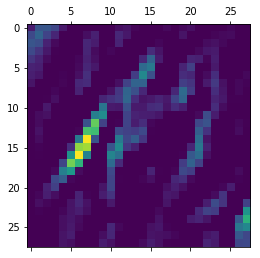

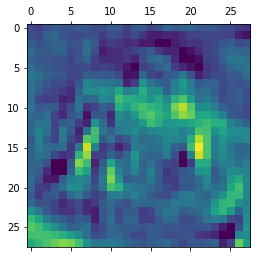

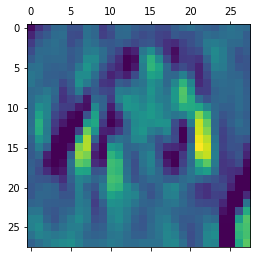

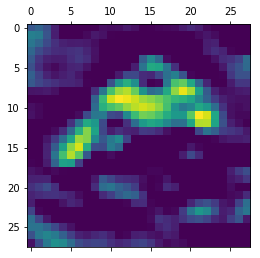

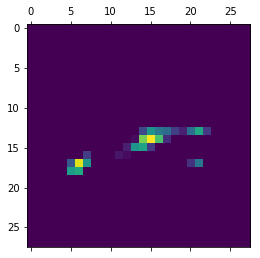

In [11]:
layer_outputs = [layer.output for layer in model.layers[:4]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(trainX)
first_layer_activation = activations[0]
for i in range(6):
    plt.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

1
(?, 32, 32, 3)
1
(?, 32, 32, 3)
1
(?, 32, 32, 3)
1
(?, 32, 32, 3)
1
(?, 32, 32, 3)
1
(?, 32, 32, 3)


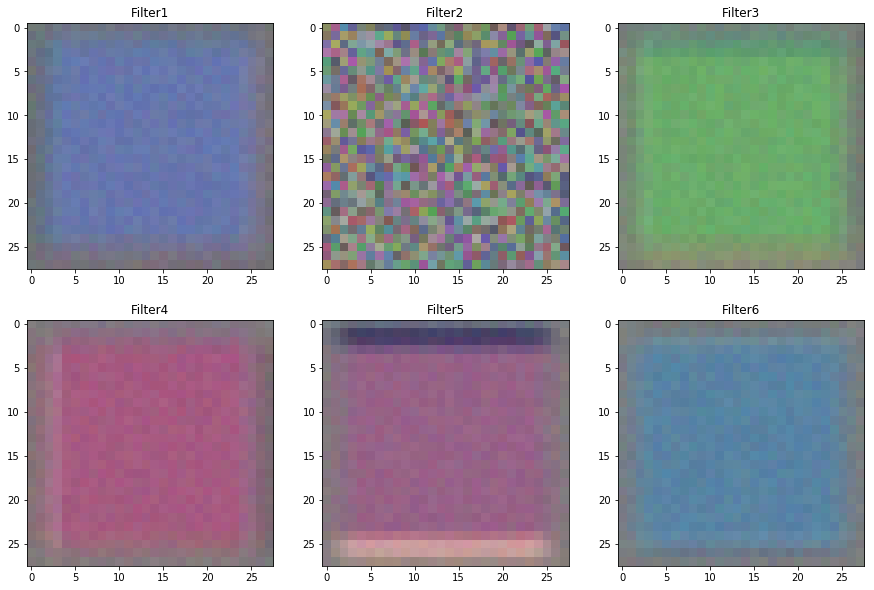

In [23]:
# Converts tensors to valid images
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x


# Functions that generate filter visualizations
def generate_pattern(filter_index, size=32):
    layer_output = model.layers[0].output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)
    print(len(grads))
    grads = grads[0]
    print(grads.shape)
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img)


# Generates a grid of all filter response patterns in a layer
size = 28
plt.figure(figsize=(15, 10))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    filter_img = generate_pattern(i, size=size)
    plt.imshow(filter_img)
    plt.grid([])
    plt.title('Filter' + str(i + 1))
plt.show()

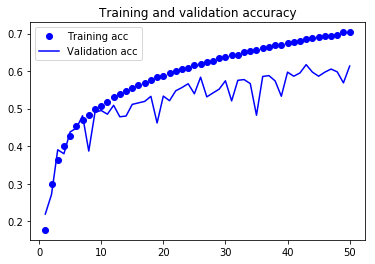

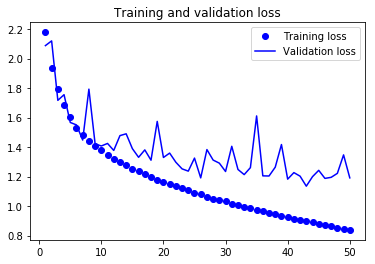

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [13]:
# model define: with dropout in FC layer
model2 = models.Sequential()
model2.add(layers.Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 3), kernel_initializer='random_normal'))
model2.add(layers.MaxPooling2D((2, 2), strides=2))
model2.add(layers.Conv2D(16, (5, 5), activation='relu', kernel_initializer='random_normal'))
model2.add(layers.MaxPooling2D((2, 2), strides=2))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(120, activation='relu'))
model2.add(layers.Dense(84, activation='relu'))
model2.add(layers.Dense(10, activation='softmax'))
sgd = optimizers.SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False)
model2.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])
history2 = model2.fit(trainX, trainY, epochs=50, batch_size=64, validation_data=(testX, testY))
print("Finished compiling 2")

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 125us/step - loss: 2.2568 - acc: 0.1440 - val_loss: 2.0845 - val_acc: 0.2281
Epoch 2/50
50000/50000 [==============================] - 6s 113us/step - loss: 2.0660 - acc: 0.2292 - val_loss: 1.9990 - val_acc: 0.2647
Epoch 3/50
50000/50000 [==============================] - 6s 114us/step - loss: 1.9553 - acc: 0.2804 - val_loss: 1.8368 - val_acc: 0.3254
Epoch 4/50
50000/50000 [==============================] - 5s 110us/step - loss: 1.8581 - acc: 0.3207 - val_loss: 1.8104 - val_acc: 0.3585
Epoch 5/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.7777 - acc: 0.3500 - val_loss: 1.7424 - val_acc: 0.3825
Epoch 6/50
50000/50000 [==============================] - 6s 111us/step - loss: 1.7015 - acc: 0.3783 - val_loss: 1.7669 - val_acc: 0.3595
Epoch 7/50
50000/50000 [==============================] - 6s 115us/step - loss: 1.6534 - acc: 0.3951 - val_loss: 1.5261 - 

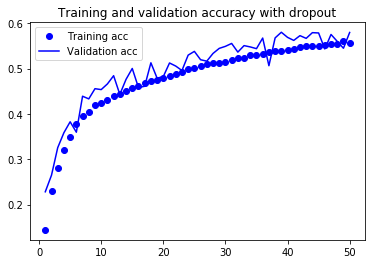

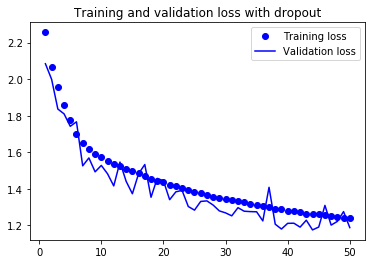

In [16]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy with dropout')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss with dropout')
plt.legend()
plt.show()

In [15]:
# model define with different initializer
model3 = models.Sequential()
model3.add(layers.Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 3), kernel_initializer='he_normal'))
model3.add(layers.MaxPooling2D((2, 2), strides=2))
model3.add(layers.Conv2D(16, (5, 5), activation='relu', kernel_initializer='he_normal'))
model3.add(layers.MaxPooling2D((2, 2), strides=2))
model3.add(layers.Flatten())
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(120, activation='relu'))
model3.add(layers.Dense(84, activation='relu'))
model3.add(layers.Dense(10, activation='softmax'))
sgd = optimizers.SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False)
model3.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])
history3 = model3.fit(trainX, trainY, epochs=50, batch_size=64, validation_data=(testX, testY))
print("Finished compiling 3")

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 129us/step - loss: 2.1725 - acc: 0.1818 - val_loss: 1.9908 - val_acc: 0.2631
Epoch 2/50
50000/50000 [==============================] - 6s 111us/step - loss: 1.9423 - acc: 0.2774 - val_loss: 1.8116 - val_acc: 0.3397
Epoch 3/50
50000/50000 [==============================] - 6s 111us/step - loss: 1.8171 - acc: 0.3299 - val_loss: 1.6826 - val_acc: 0.3912
Epoch 4/50
50000/50000 [==============================] - 6s 111us/step - loss: 1.7319 - acc: 0.3648 - val_loss: 1.6079 - val_acc: 0.4261
Epoch 5/50
50000/50000 [==============================] - 6s 111us/step - loss: 1.6763 - acc: 0.3865 - val_loss: 1.6151 - val_acc: 0.4131
Epoch 6/50
50000/50000 [==============================] - 6s 118us/step - loss: 1.6274 - acc: 0.4030 - val_loss: 1.6324 - val_acc: 0.4268
Epoch 7/50
50000/50000 [==============================] - 6s 111us/step - loss: 1.5963 - acc: 0.4165 - val_loss: 1.4863 - 

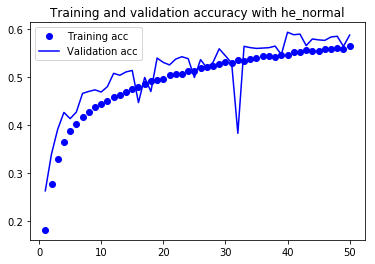

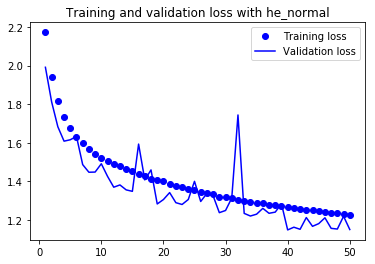

In [17]:
acc = history3.history['acc']
val_acc = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy with he_normal')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss with he_normal')
plt.legend()
plt.show()

In [21]:
# model define with batch normalization
model4 = models.Sequential()
model4.add(layers.Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 3), kernel_initializer='he_normal'))
model4.add(layers.BatchNormalization())
model4.add(layers.MaxPooling2D((2, 2), strides=2))
model4.add(layers.Conv2D(16, (5, 5), activation='relu', kernel_initializer='he_normal'))
model4.add(layers.BatchNormalization())
model4.add(layers.MaxPooling2D((2, 2), strides=2))
model4.add(layers.Flatten())
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(120, activation='relu'))
model4.add(layers.BatchNormalization())
model4.add(layers.Dense(84, activation='relu'))
model4.add(layers.BatchNormalization())
model4.add(layers.Dense(10, activation='softmax'))
sgd = optimizers.SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False)
model4.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])
history4 = model4.fit(trainX, trainY, epochs=50, batch_size=64, validation_data=(testX, testY))
print("Finished compiling 4")

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 222us/step - loss: 2.0570 - acc: 0.2751 - val_loss: 1.7417 - val_acc: 0.3667
Epoch 2/50
50000/50000 [==============================] - 9s 189us/step - loss: 1.7336 - acc: 0.3661 - val_loss: 1.5953 - val_acc: 0.4151
Epoch 3/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.6432 - acc: 0.4010 - val_loss: 1.7982 - val_acc: 0.3647
Epoch 4/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.5883 - acc: 0.4197 - val_loss: 1.5664 - val_acc: 0.4335
Epoch 5/50
50000/50000 [==============================] - 9s 188us/step - loss: 1.5492 - acc: 0.4361 - val_loss: 1.6727 - val_acc: 0.3894
Epoch 6/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.5139 - acc: 0.4486 - val_loss: 1.9039 - val_acc: 0.3319
Epoch 7/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.4809 - acc: 0.4649 - val_loss: 1.7310 -

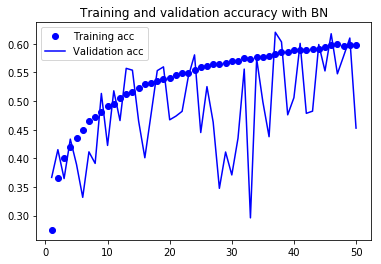

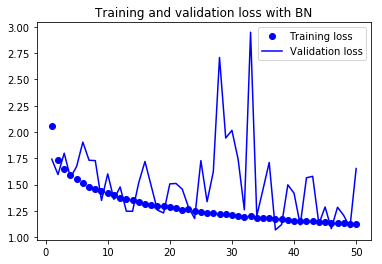

In [24]:
acc = history4.history['acc']
val_acc = history4.history['val_acc']
loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy with BN')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss with BN')
plt.legend()
plt.show()

In [37]:
# self-defined model
model5 = models.Sequential()
model5.add(layers.Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 3), kernel_initializer='he_normal'))
model5.add(layers.BatchNormalization())
model5.add(layers.MaxPooling2D((2, 2), strides=2))
model5.add(layers.Conv2D(16, (5, 5), activation='relu', kernel_initializer='he_normal'))
model5.add(layers.BatchNormalization())
model5.add(layers.MaxPooling2D((2, 2), strides=2))
model5.add(layers.Flatten())
model5.add(layers.Dropout(0.5))
model5.add(layers.Dense(120, activation='relu'))
model5.add(layers.Dense(84, activation='relu'))
model5.add(layers.Dense(10, activation='softmax'))
sgd = optimizers.SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False)
model5.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])

In [38]:
train_datagen = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_datagen.fit(trainX, seed=0, augment=True)
test_generator = ImageDataGenerator(zca_epsilon=0, horizontal_flip=True, fill_mode='reflect', )
test_generator.fit(testX, seed=0, augment=True)
history5 = model5.fit_generator(train_datagen.flow(trainX, trainY, batch_size=256), steps_per_epoch=100, epochs=50,
                                validation_data=test_generator.flow(testX, testY, batch_size=256),validation_steps=50)

Epoch 1/50
100/100 [==============================] - 18s 184ms/step - loss: 2.4497 - acc: 0.1496 - val_loss: 2.1303 - val_acc: 0.2150
Epoch 2/50
100/100 [==============================] - 17s 166ms/step - loss: 2.1910 - acc: 0.1937 - val_loss: 2.0811 - val_acc: 0.2252
Epoch 3/50
100/100 [==============================] - 18s 179ms/step - loss: 2.1124 - acc: 0.2171 - val_loss: 1.9642 - val_acc: 0.2743
Epoch 4/50
100/100 [==============================] - 18s 181ms/step - loss: 2.0563 - acc: 0.2299 - val_loss: 1.8934 - val_acc: 0.3066
Epoch 5/50
100/100 [==============================] - 18s 178ms/step - loss: 2.0167 - acc: 0.2464 - val_loss: 1.8866 - val_acc: 0.3100
Epoch 6/50
100/100 [==============================] - 18s 182ms/step - loss: 1.9925 - acc: 0.2553 - val_loss: 1.8476 - val_acc: 0.3218
Epoch 7/50
100/100 [==============================] - 16s 164ms/step - loss: 1.9582 - acc: 0.2674 - val_loss: 2.0099 - val_acc: 0.2675
Epoch 8/50
100/100 [==============================] - 1

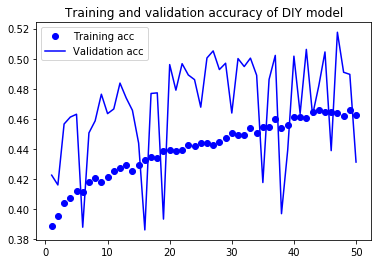

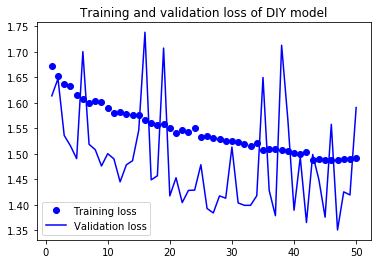

In [33]:
acc = history5.history['acc']
val_acc = history5.history['val_acc']
loss = history5.history['loss']
val_loss = history5.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy of DIY model')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss of DIY model')
plt.legend()
plt.show()

In [15]:
# model5.add(layers.Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 3), kernel_initializer='he_normal'))
# self-defined model based on VGG-16
model6 = models.Sequential()
model6.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=trainX.shape[1:]))
model6.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=trainX.shape[1:]))
model6.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=trainX.shape[1:]))
model6.add(layers.Conv2D(48, (3, 3), activation='relu',padding='same', input_shape=trainX.shape[1:]))
model6.add(layers.Conv2D(48, (3, 3), activation='relu',padding='same', input_shape=trainX.shape[1:]))
model6.add(layers.MaxPooling2D(pool_size=(2, 2)))
model6.add(layers.Dropout(0.25))
model6.add(layers.Conv2D(80, (3, 3), activation='relu',padding='same', input_shape=trainX.shape[1:]))
model6.add(layers.Conv2D(80, (3, 3), activation='relu',padding='same', input_shape=trainX.shape[1:]))
model6.add(layers.Conv2D(80, (3, 3), activation='relu',padding='same', input_shape=trainX.shape[1:]))
model6.add(layers.Conv2D(80, (3, 3), activation='relu',padding='same', input_shape=trainX.shape[1:]))
model6.add(layers.Conv2D(80, (3, 3), activation='relu',padding='same', input_shape=trainX.shape[1:]))
model6.add(layers.MaxPooling2D(pool_size=(2, 2)))
model6.add(layers.Dropout(0.25))
model6.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same', input_shape=trainX.shape[1:]))
model6.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same', input_shape=trainX.shape[1:]))
model6.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same', input_shape=trainX.shape[1:]))
model6.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same', input_shape=trainX.shape[1:]))
model6.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same', input_shape=trainX.shape[1:]))
model6.add(layers.GlobalMaxPooling2D())
model6.add(layers.Dropout(0.25))
model6.add(layers.Dense(500, activation='relu'))
model6.add(layers.Dropout(0.25))
model6.add(layers.Dense(10, activation='softmax'))
sgd = optimizers.SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False)
model6.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])

train_datagen = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_datagen.fit(trainX, seed=0, augment=True)
test_generator = ImageDataGenerator(zca_epsilon=0, horizontal_flip=True, fill_mode='reflect', )
test_generator.fit(testX, seed=0, augment=True)
history6 = model6.fit_generator(train_datagen.flow(trainX, trainY, batch_size=64), steps_per_epoch=100, epochs=800,
                                validation_data=test_generator.flow(testX, testY, batch_size=64),validation_steps=50)
print("Finished compiling 6")

Epoch 1/800
100/100 [==============================] - 7s 73ms/step - loss: 2.3025 - acc: 0.1011 - val_loss: 2.3025 - val_acc: 0.1000
Epoch 2/800
100/100 [==============================] - 4s 44ms/step - loss: 2.3025 - acc: 0.0994 - val_loss: 2.3025 - val_acc: 0.1483
Epoch 3/800
100/100 [==============================] - 5s 48ms/step - loss: 2.3024 - acc: 0.1156 - val_loss: 2.3024 - val_acc: 0.0999
Epoch 4/800
100/100 [==============================] - 6s 56ms/step - loss: 2.3023 - acc: 0.1072 - val_loss: 2.3024 - val_acc: 0.1264
Epoch 5/800
100/100 [==============================] - 6s 55ms/step - loss: 2.3022 - acc: 0.1205 - val_loss: 2.3022 - val_acc: 0.1000
Epoch 6/800
100/100 [==============================] - 6s 59ms/step - loss: 2.3021 - acc: 0.1127 - val_loss: 2.3021 - val_acc: 0.1199
Epoch 7/800
100/100 [==============================] - 5s 49ms/step - loss: 2.3019 - acc: 0.1177 - val_loss: 2.3020 - val_acc: 0.1074
Epoch 8/800
100/100 [==============================] - 5s 55ms

Epoch 62/800
100/100 [==============================] - 6s 55ms/step - loss: 1.9257 - acc: 0.2731 - val_loss: 1.8029 - val_acc: 0.3287
Epoch 63/800
100/100 [==============================] - 5s 54ms/step - loss: 1.9281 - acc: 0.2752 - val_loss: 1.8222 - val_acc: 0.3225
Epoch 64/800
100/100 [==============================] - 6s 57ms/step - loss: 1.9208 - acc: 0.2802 - val_loss: 1.8085 - val_acc: 0.3258
Epoch 65/800
100/100 [==============================] - 6s 60ms/step - loss: 1.9285 - acc: 0.2672 - val_loss: 1.8149 - val_acc: 0.3189
Epoch 66/800
100/100 [==============================] - 6s 56ms/step - loss: 1.9082 - acc: 0.2863 - val_loss: 1.8055 - val_acc: 0.3276
Epoch 67/800
100/100 [==============================] - 6s 58ms/step - loss: 1.8998 - acc: 0.2817 - val_loss: 1.7801 - val_acc: 0.3390
Epoch 68/800
100/100 [==============================] - 6s 62ms/step - loss: 1.9091 - acc: 0.2852 - val_loss: 1.8086 - val_acc: 0.3211
Epoch 69/800
100/100 [==============================] -

100/100 [==============================] - 5s 52ms/step - loss: 1.7504 - acc: 0.3514 - val_loss: 1.6234 - val_acc: 0.3945
Epoch 123/800
100/100 [==============================] - 5s 55ms/step - loss: 1.7707 - acc: 0.3492 - val_loss: 1.6219 - val_acc: 0.4017
Epoch 124/800
100/100 [==============================] - 5s 49ms/step - loss: 1.7626 - acc: 0.3488 - val_loss: 1.6104 - val_acc: 0.4060
Epoch 125/800
100/100 [==============================] - 5s 53ms/step - loss: 1.7813 - acc: 0.3347 - val_loss: 1.6991 - val_acc: 0.3783
Epoch 126/800
100/100 [==============================] - 5s 51ms/step - loss: 1.7501 - acc: 0.3502 - val_loss: 1.6130 - val_acc: 0.4009
Epoch 127/800
100/100 [==============================] - 5s 51ms/step - loss: 1.7624 - acc: 0.3473 - val_loss: 1.6242 - val_acc: 0.3942
Epoch 128/800
100/100 [==============================] - 5s 53ms/step - loss: 1.7631 - acc: 0.3448 - val_loss: 1.6042 - val_acc: 0.4029
Epoch 129/800
100/100 [==============================] - 4s 45

100/100 [==============================] - 5s 52ms/step - loss: 1.6623 - acc: 0.3931 - val_loss: 1.5215 - val_acc: 0.4338
Epoch 183/800
100/100 [==============================] - 5s 51ms/step - loss: 1.6493 - acc: 0.3953 - val_loss: 1.4974 - val_acc: 0.4452
Epoch 184/800
100/100 [==============================] - 6s 58ms/step - loss: 1.6652 - acc: 0.3816 - val_loss: 1.6743 - val_acc: 0.3911
Epoch 185/800
100/100 [==============================] - 6s 58ms/step - loss: 1.6435 - acc: 0.3881 - val_loss: 1.5007 - val_acc: 0.4468
Epoch 186/800
100/100 [==============================] - 6s 58ms/step - loss: 1.6701 - acc: 0.3880 - val_loss: 1.4910 - val_acc: 0.4502
Epoch 187/800
100/100 [==============================] - 6s 62ms/step - loss: 1.6575 - acc: 0.3864 - val_loss: 1.4880 - val_acc: 0.4506
Epoch 188/800
100/100 [==============================] - 5s 54ms/step - loss: 1.6626 - acc: 0.3850 - val_loss: 1.6009 - val_acc: 0.4138
Epoch 189/800
100/100 [==============================] - 5s 50

100/100 [==============================] - 6s 60ms/step - loss: 1.5581 - acc: 0.4320 - val_loss: 1.3841 - val_acc: 0.4880
Epoch 243/800
100/100 [==============================] - 5s 55ms/step - loss: 1.5623 - acc: 0.4211 - val_loss: 1.5111 - val_acc: 0.4550
Epoch 244/800
100/100 [==============================] - 6s 56ms/step - loss: 1.5388 - acc: 0.4341 - val_loss: 1.3666 - val_acc: 0.4956
Epoch 245/800
100/100 [==============================] - 6s 58ms/step - loss: 1.5273 - acc: 0.4381 - val_loss: 1.3681 - val_acc: 0.4947
Epoch 246/800
100/100 [==============================] - 5s 45ms/step - loss: 1.5668 - acc: 0.4291 - val_loss: 1.4676 - val_acc: 0.4649
Epoch 247/800
100/100 [==============================] - 5s 50ms/step - loss: 1.5514 - acc: 0.4252 - val_loss: 1.3520 - val_acc: 0.5054
Epoch 248/800
100/100 [==============================] - 6s 59ms/step - loss: 1.5231 - acc: 0.4383 - val_loss: 1.3679 - val_acc: 0.4948
Epoch 249/800
100/100 [==============================] - 6s 56

100/100 [==============================] - 6s 61ms/step - loss: 1.4177 - acc: 0.4873 - val_loss: 1.2673 - val_acc: 0.5368
Epoch 303/800
100/100 [==============================] - 6s 59ms/step - loss: 1.4095 - acc: 0.4828 - val_loss: 1.2750 - val_acc: 0.5420
Epoch 304/800
100/100 [==============================] - 6s 59ms/step - loss: 1.4041 - acc: 0.4916 - val_loss: 1.2280 - val_acc: 0.5489
Epoch 305/800
100/100 [==============================] - 6s 58ms/step - loss: 1.4179 - acc: 0.4847 - val_loss: 1.2228 - val_acc: 0.5526
Epoch 306/800
100/100 [==============================] - 5s 52ms/step - loss: 1.4077 - acc: 0.4875 - val_loss: 1.2500 - val_acc: 0.5477
Epoch 307/800
100/100 [==============================] - 5s 50ms/step - loss: 1.4207 - acc: 0.4794 - val_loss: 1.2901 - val_acc: 0.5250
Epoch 308/800
100/100 [==============================] - 5s 53ms/step - loss: 1.3998 - acc: 0.4866 - val_loss: 1.2323 - val_acc: 0.5520
Epoch 309/800
100/100 [==============================] - 5s 50

100/100 [==============================] - 5s 54ms/step - loss: 1.2786 - acc: 0.5431 - val_loss: 1.3081 - val_acc: 0.5441
Epoch 363/800
100/100 [==============================] - 5s 52ms/step - loss: 1.3054 - acc: 0.5262 - val_loss: 1.3213 - val_acc: 0.5351
Epoch 364/800
100/100 [==============================] - 5s 54ms/step - loss: 1.2712 - acc: 0.5397 - val_loss: 1.1295 - val_acc: 0.5944
Epoch 365/800
100/100 [==============================] - 5s 53ms/step - loss: 1.2873 - acc: 0.5373 - val_loss: 1.1643 - val_acc: 0.5752
Epoch 366/800
100/100 [==============================] - 5s 54ms/step - loss: 1.3015 - acc: 0.5261 - val_loss: 1.1455 - val_acc: 0.5864
Epoch 367/800
100/100 [==============================] - 6s 59ms/step - loss: 1.2664 - acc: 0.5534 - val_loss: 1.2865 - val_acc: 0.5276
Epoch 368/800
100/100 [==============================] - 6s 57ms/step - loss: 1.2811 - acc: 0.5380 - val_loss: 1.0936 - val_acc: 0.6027
Epoch 369/800
100/100 [==============================] - 5s 50

100/100 [==============================] - 6s 56ms/step - loss: 1.1539 - acc: 0.5814 - val_loss: 1.2195 - val_acc: 0.5731
Epoch 423/800
100/100 [==============================] - 5s 46ms/step - loss: 1.1643 - acc: 0.5863 - val_loss: 1.0979 - val_acc: 0.6091
Epoch 424/800
100/100 [==============================] - 5s 47ms/step - loss: 1.1719 - acc: 0.5730 - val_loss: 1.1045 - val_acc: 0.6053
Epoch 425/800
100/100 [==============================] - 6s 56ms/step - loss: 1.1673 - acc: 0.5837 - val_loss: 1.0996 - val_acc: 0.6181
Epoch 426/800
100/100 [==============================] - 6s 56ms/step - loss: 1.1506 - acc: 0.5881 - val_loss: 1.0337 - val_acc: 0.6310
Epoch 427/800
100/100 [==============================] - 6s 57ms/step - loss: 1.1915 - acc: 0.5767 - val_loss: 1.1165 - val_acc: 0.6026
Epoch 428/800
100/100 [==============================] - 6s 60ms/step - loss: 1.1540 - acc: 0.5897 - val_loss: 1.0141 - val_acc: 0.6401
Epoch 429/800
100/100 [==============================] - 6s 60

100/100 [==============================] - 6s 58ms/step - loss: 1.0756 - acc: 0.6213 - val_loss: 0.9418 - val_acc: 0.6722
Epoch 483/800
100/100 [==============================] - 6s 55ms/step - loss: 1.0429 - acc: 0.6348 - val_loss: 1.0909 - val_acc: 0.6226
Epoch 484/800
100/100 [==============================] - 6s 56ms/step - loss: 1.0670 - acc: 0.6197 - val_loss: 0.8777 - val_acc: 0.6850
Epoch 485/800
100/100 [==============================] - 5s 54ms/step - loss: 1.0303 - acc: 0.6317 - val_loss: 0.9280 - val_acc: 0.6726
Epoch 486/800
100/100 [==============================] - 5s 50ms/step - loss: 1.0611 - acc: 0.6287 - val_loss: 1.1227 - val_acc: 0.6159
Epoch 487/800
100/100 [==============================] - 6s 58ms/step - loss: 1.0479 - acc: 0.6231 - val_loss: 0.9986 - val_acc: 0.6523
Epoch 488/800
100/100 [==============================] - 6s 55ms/step - loss: 1.0544 - acc: 0.6292 - val_loss: 0.9717 - val_acc: 0.6505
Epoch 489/800
100/100 [==============================] - 6s 58

100/100 [==============================] - 5s 51ms/step - loss: 0.9625 - acc: 0.6694 - val_loss: 0.8475 - val_acc: 0.7065
Epoch 543/800
100/100 [==============================] - 5s 53ms/step - loss: 0.9550 - acc: 0.6667 - val_loss: 0.8835 - val_acc: 0.7011
Epoch 544/800
100/100 [==============================] - 5s 51ms/step - loss: 0.9576 - acc: 0.6655 - val_loss: 0.9067 - val_acc: 0.6895
Epoch 545/800
100/100 [==============================] - 5s 48ms/step - loss: 0.9298 - acc: 0.6723 - val_loss: 0.9443 - val_acc: 0.6872
Epoch 546/800
100/100 [==============================] - 5s 48ms/step - loss: 0.9427 - acc: 0.6702 - val_loss: 0.9316 - val_acc: 0.6955
Epoch 547/800
100/100 [==============================] - 5s 55ms/step - loss: 0.9259 - acc: 0.6742 - val_loss: 0.8970 - val_acc: 0.6916
Epoch 548/800
100/100 [==============================] - 6s 57ms/step - loss: 0.9309 - acc: 0.6769 - val_loss: 0.8307 - val_acc: 0.7112
Epoch 549/800
100/100 [==============================] - 6s 59

100/100 [==============================] - 6s 58ms/step - loss: 0.8792 - acc: 0.6948 - val_loss: 0.7644 - val_acc: 0.7339
Epoch 603/800
100/100 [==============================] - 5s 54ms/step - loss: 0.8790 - acc: 0.6916 - val_loss: 0.8732 - val_acc: 0.7024
Epoch 604/800
100/100 [==============================] - 6s 56ms/step - loss: 0.8845 - acc: 0.6961 - val_loss: 0.9792 - val_acc: 0.6776
Epoch 605/800
100/100 [==============================] - 5s 49ms/step - loss: 0.8921 - acc: 0.6873 - val_loss: 0.8549 - val_acc: 0.7082
Epoch 606/800
100/100 [==============================] - 6s 56ms/step - loss: 0.8430 - acc: 0.7141 - val_loss: 0.9083 - val_acc: 0.6951
Epoch 607/800
100/100 [==============================] - 6s 60ms/step - loss: 0.8719 - acc: 0.6995 - val_loss: 0.7871 - val_acc: 0.7345
Epoch 608/800
100/100 [==============================] - 6s 57ms/step - loss: 0.8561 - acc: 0.6991 - val_loss: 0.9475 - val_acc: 0.6916
Epoch 609/800
100/100 [==============================] - 6s 57

100/100 [==============================] - 6s 58ms/step - loss: 0.8112 - acc: 0.7209 - val_loss: 0.6594 - val_acc: 0.7717
Epoch 663/800
100/100 [==============================] - 6s 57ms/step - loss: 0.8039 - acc: 0.7178 - val_loss: 0.7570 - val_acc: 0.7406
Epoch 664/800
100/100 [==============================] - 6s 58ms/step - loss: 0.7954 - acc: 0.7270 - val_loss: 0.7262 - val_acc: 0.7546
Epoch 665/800
100/100 [==============================] - 6s 56ms/step - loss: 0.8246 - acc: 0.7178 - val_loss: 0.7431 - val_acc: 0.7466
Epoch 666/800
100/100 [==============================] - 6s 58ms/step - loss: 0.8068 - acc: 0.7236 - val_loss: 0.8695 - val_acc: 0.7117
Epoch 667/800
100/100 [==============================] - 6s 56ms/step - loss: 0.8135 - acc: 0.7219 - val_loss: 0.7440 - val_acc: 0.7433
Epoch 668/800
100/100 [==============================] - 6s 58ms/step - loss: 0.7920 - acc: 0.7305 - val_loss: 0.7613 - val_acc: 0.7413
Epoch 669/800
100/100 [==============================] - 6s 59

100/100 [==============================] - 6s 58ms/step - loss: 0.7469 - acc: 0.7461 - val_loss: 0.7037 - val_acc: 0.7611
Epoch 723/800
100/100 [==============================] - 6s 57ms/step - loss: 0.7335 - acc: 0.7445 - val_loss: 0.6190 - val_acc: 0.7857
Epoch 724/800
100/100 [==============================] - 6s 58ms/step - loss: 0.7567 - acc: 0.7322 - val_loss: 0.6363 - val_acc: 0.7835
Epoch 725/800
100/100 [==============================] - 5s 53ms/step - loss: 0.7366 - acc: 0.7377 - val_loss: 0.7829 - val_acc: 0.7398
Epoch 726/800
100/100 [==============================] - 6s 60ms/step - loss: 0.7378 - acc: 0.7486 - val_loss: 0.7177 - val_acc: 0.7600
Epoch 727/800
100/100 [==============================] - 5s 52ms/step - loss: 0.7337 - acc: 0.7461 - val_loss: 0.7262 - val_acc: 0.7507
Epoch 728/800
100/100 [==============================] - 6s 61ms/step - loss: 0.7083 - acc: 0.7559 - val_loss: 0.6825 - val_acc: 0.7738
Epoch 729/800
100/100 [==============================] - 6s 59

100/100 [==============================] - 6s 58ms/step - loss: 0.7029 - acc: 0.7634 - val_loss: 0.5946 - val_acc: 0.7998
Epoch 783/800
100/100 [==============================] - 6s 58ms/step - loss: 0.6900 - acc: 0.7641 - val_loss: 0.5873 - val_acc: 0.8029
Epoch 784/800
100/100 [==============================] - 6s 55ms/step - loss: 0.6766 - acc: 0.7670 - val_loss: 0.6191 - val_acc: 0.7933
Epoch 785/800
100/100 [==============================] - 6s 56ms/step - loss: 0.6874 - acc: 0.7639 - val_loss: 0.6757 - val_acc: 0.7729
Epoch 786/800
100/100 [==============================] - 6s 56ms/step - loss: 0.7043 - acc: 0.7613 - val_loss: 0.6400 - val_acc: 0.7840
Epoch 787/800
100/100 [==============================] - 6s 56ms/step - loss: 0.6781 - acc: 0.7662 - val_loss: 0.6432 - val_acc: 0.7885
Epoch 788/800
100/100 [==============================] - 6s 57ms/step - loss: 0.6990 - acc: 0.7591 - val_loss: 0.5515 - val_acc: 0.8112
Epoch 789/800
100/100 [==============================] - 6s 56

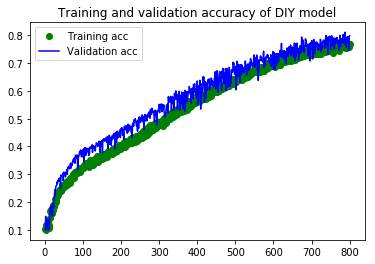

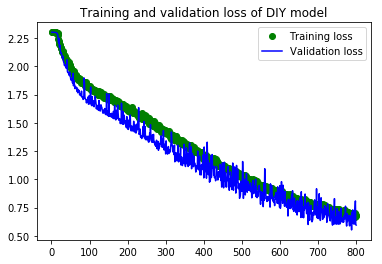

In [19]:
acc = history6.history['acc']
val_acc = history6.history['val_acc']
loss = history6.history['loss']
val_loss = history6.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy of DIY model')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss of DIY model')
plt.legend()
plt.show()